In [1]:
from typing import Tuple, Sequence, Dict, Union, Optional, Callable
import numpy as np
import math
import torch
import torch.nn as nn
from diffusers.optimization import get_scheduler
from tqdm.auto import tqdm

import gym
from gym import spaces
import pygame
import pymunk
import pymunk.pygame_util
from pymunk.space_debug_draw_options import SpaceDebugColor
from pymunk.vec2d import Vec2d
import shapely.geometry as sg
import cv2
import skimage.transform as st
from skvideo.io import vwrite
from IPython.display import Video
import gdown
import os


# from diffusion_policy.env.pusht.pusht_image_env import PushTImageEnv
import imageio 
import torch
import torch.nn as nn
import torch.nn.functional as F

import h5py

from diffusion_policy.pusht_data_utils import get_data_stats, normalize_data, unnormalize_data, PushTImageDatasetFromHDF5
from diffusion_policy.vision_model import ResidualBlock, ResNetFe, replace_bn_with_gn
from diffusion_policy.noise_predictor_model import ConditionalUnet1D

from typing import Tuple, Sequence, Dict, Union, Optional, Callable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import math
import numpy as np
import matplotlib.pyplot as plt

/home/ns1254/miniforge3/envs/robodiff/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pygame 2.1.2 (SDL 2.0.16, Python 3.9.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


/home/ns1254/miniforge3/envs/robodiff/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

In [3]:
noisy_actions = torch.randn(64, 16, 2).to(device)
timesteps = torch.randint(0, 100, (64,)).to(device)
obs_cond = torch.randn(64, 1028).to(device)

noisy_actions.shape, timesteps.shape, obs_cond.shape

(torch.Size([64, 16, 2]), torch.Size([64]), torch.Size([64, 1028]))

In [ ]:
noise_pred_net = ConditionalUnet1D(
    input_dim=2,
    global_cond_dim=1028
)
noise_pred_net = noise_pred_net.to(device)

In [ ]:
eps_theta = noise_pred_net(noisy_actions, timesteps, global_cond=obs_cond)
eps_theta.shape

/home/ns1254/miniforge3/envs/robodiff/lib/python3.9/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,


torch.Size([64, 16, 2])

In [ ]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

In [8]:
class PositionalEncoding(nn.Module):
    """Positional encoding."""
    def __init__(self, d_model, max_len=1000):
        super(PositionalEncoding, self).__init__()

        
        self.d_model = d_model
        self.max_len = max_len  
        t = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) # positions 

        fs=[1.0 /( 10000**(2*i/d_model) ) for i in range(0, d_model//2)]  #high to low frequency
        fs= torch.tensor(fs)
    
        sins=torch.sin(t * fs)
        coss=torch.cos(t * fs) 
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = sins
        pe[:, 1::2] = coss  
        self.register_buffer('pe', pe.unsqueeze(0)) 
        
    def forward(self, timesteps): 
        X= timesteps 
        X = self.pe[:, :X.size(-1)]   
        return X.squeeze()

In [9]:
class Conv1dBlock(nn.Module):
    '''
        Conv1d --> GroupNorm --> Mish
    '''

    def __init__(self, inp_channels, out_channels, kernel_size, n_groups=8):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv1d(inp_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.GroupNorm(n_groups, out_channels),
            nn.Mish(),
        )

    def forward(self, x):
        return self.block(x)
    

In [10]:
class FiLM(nn.Module):
    def __init__(self, out_channels, cond_dim):
        super().__init__()
        # FiLM modulation https://arxiv.org/abs/1709.07871 
        cond_channels = out_channels * 2
        self.out_channels = out_channels
        self.cond_encoder = nn.Sequential(
            nn.Mish(),
            nn.Linear(cond_dim, cond_channels),
            nn.Unflatten(-1, (-1, 1))
        )

    def forward(self, x, cond):
        embed = self.cond_encoder(cond)

        embed = embed.reshape( embed.shape[0], 2, self.out_channels, 1)
        gamma = embed[:,0,...]
        beta = embed[:,1,...]
        
        out = gamma * x + beta    # FiLM modulation
        return out

In [11]:
class ConditionalResidualBlock1D(nn.Module):
    def __init__(self,
            in_channels,
            out_channels,
            cond_dim,
            kernel_size=3,
            n_groups=8):
        super().__init__()
 

        self.block1=Conv1dBlock(in_channels, out_channels, kernel_size, n_groups=n_groups)
        self.block2=Conv1dBlock(out_channels, out_channels, kernel_size, n_groups=n_groups)


        self.film = FiLM(out_channels, cond_dim) 
        # make sure dimensions compatible
        self.residual_conv = nn.Conv1d(in_channels, out_channels, 1) \
            if in_channels != out_channels else nn.Identity()

    def forward(self, x, cond):
        '''
            x : [ batch_size x in_channels x horizon ]
            cond : [ batch_size x cond_dim]

            returns:
            out : [ batch_size x out_channels x horizon ]
        '''
        out = self.block1(x) 
        out = self.film(out, cond)  
        out = self.block2(out)
        out = out + self.residual_conv(x)
        return out 

In [12]:
class DownModule(nn.Module):
    def __init__(self, dim_in, dim_out, cond_dim, kernel_size, n_groups, is_last=False):
        super().__init__()
        self.crb=ConditionalResidualBlock1D(
                    dim_in, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups) 
        if is_last:
            self.downsample = nn.Identity()
        else: 
            self.downsample  =  nn.Conv1d(dim_out, dim_out, 3, 2, 1)
 
    def forward(self, x, cond):
        x = self.crb(x, cond)
        x_small = self.downsample(x)

        return x, x_small
    
class UpModule(nn.Module):
    def __init__(self, dim_in, dim_out, cond_dim, kernel_size, n_groups, is_last=False):
        super().__init__()
        if is_last:
            self.upsample = nn.Identity()
        else: 
            self.upsample = nn.ConvTranspose1d(dim_out, dim_out, 4, 2, 1)
    
        self.crb = ConditionalResidualBlock1D(
                    dim_in, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups) 

    def forward(self, x, x_down, cond):
        x = torch.cat((x, x_down), dim=1)    #unet skip connection
        x = self.crb(x, cond)
        x = self.upsample(x)  
        return x


In [13]:
class ConditionalUnet1D(nn.Module):
    def __init__(self,
        input_dim,
        global_cond_dim,
        diffusion_step_embed_dim=256,
        down_dims=[256,512,1024],
        kernel_size=5,
        n_groups=8
        ):
        """
        input_dim: Dim of actions.
        global_cond_dim: Dim of global conditioning applied with FiLM
          in addition to diffusion step embedding. This is usually obs_horizon * obs_dim
        diffusion_step_embed_dim: Size of positional encoding for diffusion iteration k
        down_dims: Channel size for each UNet level.
          The length of this array determines numebr of levels.
        kernel_size: Conv kernel size
        n_groups: Number of groups for GroupNorm
        """

        super().__init__()
        all_dims = [input_dim] + list(down_dims)
        start_dim = down_dims[0]

        dsed = diffusion_step_embed_dim
        diffusion_step_encoder = nn.Sequential(
            PositionalEncoding(dsed, max_len=64),
            nn.Linear(dsed, dsed * 4),
            nn.Mish(),
            nn.Linear(dsed * 4, dsed),
        )
        cond_dim = dsed + global_cond_dim

        in_out = list(zip(all_dims[:-1], all_dims[1:]))
        mid_dim = all_dims[-1]
        self.mid_modules = nn.ModuleList([
            ConditionalResidualBlock1D(
                mid_dim, mid_dim, cond_dim=cond_dim,
                kernel_size=kernel_size, n_groups=n_groups
            ), 
        ])

        down_modules = nn.ModuleList([])  
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (len(in_out) - 1)
            down_modules.append(
                DownModule(dim_in, dim_out, cond_dim, kernel_size, n_groups, is_last)
            )  

        up_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (len(in_out) - 1)
            up_modules.append(
                UpModule(dim_out*2, dim_in, cond_dim, kernel_size, n_groups, is_last)
            )  

        final_conv = nn.Sequential(
            Conv1dBlock(start_dim, start_dim, kernel_size=kernel_size),
            nn.Conv1d(start_dim, input_dim, 1),
        )

        self.diffusion_step_encoder = diffusion_step_encoder
        self.up_modules = up_modules
        self.down_modules = down_modules
        self.final_conv = final_conv 

 
    def forward(self,
            sample: torch.Tensor,
            timestep: Union[torch.Tensor, float, int],
            global_cond=None):
        """
        x: (B,T,input_dim)
        timestep: (B,) or int, diffusion step
        global_cond: (B,global_cond_dim)
        output: (B,T,input_dim)
        """
        # (B,T,C)
        sample = sample.moveaxis(-1,-2)  # (B,C,T)

        # 1. time 
        timestep  = timestep.expand(sample.shape[0]) 
        positional_feature = self.diffusion_step_encoder(timestep)

        global_feature = torch.cat([positional_feature, global_cond], axis=-1)

        # unet training
        x = sample
        h = []
        for idx, down_module in enumerate(self.down_modules):
            x, x_small = down_module(x, global_feature) 
            h.append(x)
            x = x_small 

        for mid_module in self.mid_modules:
            x = mid_module(x, global_feature)

        for idx, upmodule  in enumerate(self.up_modules):
            x= upmodule(x, h.pop(), global_feature) 

        x = self.final_conv(x)

        # (B,C,T)
        x = x.moveaxis(-1,-2)
        # (B,T,C)
        return x


In [14]:
noise_pred_net = ConditionalUnet1D(
    input_dim=2,
    global_cond_dim=1028
)
noise_pred_net = noise_pred_net.to(device)

In [15]:
eps_theta = noise_pred_net(noisy_actions, timesteps, global_cond=obs_cond)
eps_theta.shape

/home/ns1254/miniforge3/envs/robodiff/lib/python3.9/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,


torch.Size([64, 16, 2])

In [16]:
timestep=timesteps
sample=noisy_actions
sample = sample.moveaxis(-1,-2)  # (B,C,T)

timestep  = timestep.expand(sample.shape[0]) 
timestep.shape

torch.Size([64])

In [17]:
positional_feature = noise_pred_net.diffusion_step_encoder(timestep)
positional_feature.shape

torch.Size([64, 256])

In [19]:
# dsed=256
# sp=SinusoidalPosEmb(dsed)
# sp(timestep).shape

In [18]:
x=timestep
x.shape

torch.Size([64])

In [19]:
device = x.device
half_dim = sp.dim // 2
half_dim

128

In [21]:
emb = math.log(10000) / (half_dim - 1)
emb 

0.07252236513367073

In [22]:
emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
emb.shape

torch.Size([128])

In [24]:
emb = x[:, None] * emb[None, :] 

In [26]:
emb.shape

torch.Size([64, 128])

In [27]:
emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
emb.shape

torch.Size([64, 256])

In [33]:
def sinusoidal_pe(max_position, d_model):
    t = np.arange(max_position).reshape(-1, 1)                       # positions 
    fs=[1.0/( 10000**(2*i/d_model) ) for i in range(0, d_model//2)]  #high to low frequency

    sins=np.sin(t * fs)
    coss=np.cos(t * fs)

    pe=np.zeros((max_position, d_model))
    pe[:, 0::2] = sins
    pe[:, 1::2] = coss
    return pe

In [34]:
max_position = 64  
d_model = 256 
pe = sinusoidal_pe(max_position, d_model)
pe.shape

(64, 256)

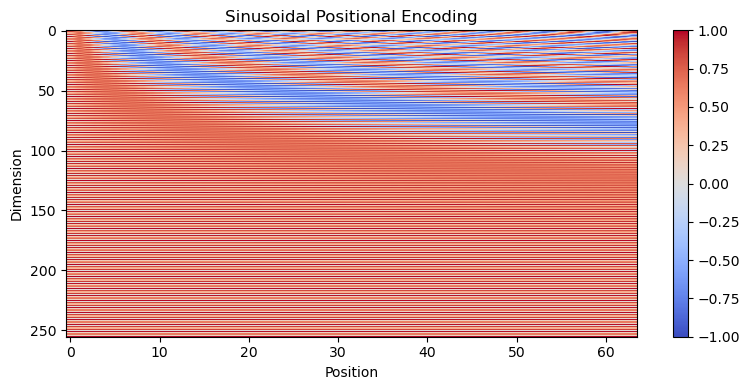

In [35]:
plt.figure(figsize=(8, 4))
plt.imshow(pe.T, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Sinusoidal Positional Encoding')
plt.xlabel('Position')
plt.ylabel('Dimension')
plt.tight_layout()
plt.show()

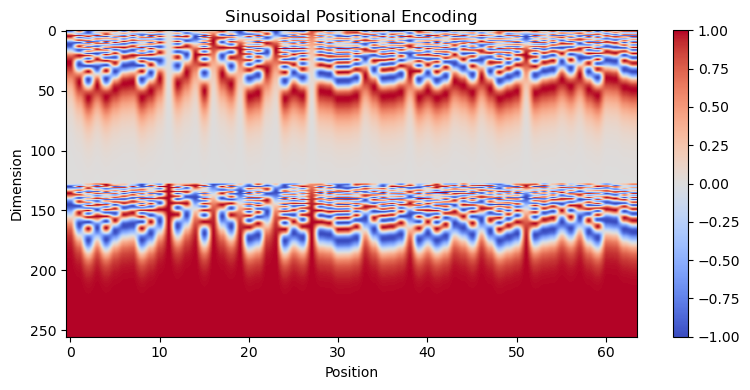

In [37]:
plt.figure(figsize=(8, 4))
plt.imshow(emb.detach().cpu().numpy().T, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Sinusoidal Positional Encoding')
plt.xlabel('Position')
plt.ylabel('Dimension')
plt.tight_layout()
plt.show()

In [ ]:
class PositionalEncoding(nn.Module):
    """Positional encoding."""
    def __init__(self, d_model, max_len=1000):
        super(PositionalEncoding, self).__init__()

        
        self.d_model = d_model
        self.max_len = max_len  
        t = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) # positions 

        fs=[1.0 /( 10000**(2*i/d_model) ) for i in range(0, d_model//2)]  #high to low frequency
        fs= torch.tensor(fs)
    
        sins=torch.sin(t * fs)
        coss=torch.cos(t * fs) 
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = sins
        pe[:, 1::2] = coss  
        self.register_buffer('pe', pe.unsqueeze(0)) 
        
    def forward(self, timesteps): 
        X= timesteps 
        X = self.pe[:, :X.size(-1)]   
        return X.squeeze()

In [41]:
pes=PositionalEncoding(d_model=256, max_len=64)
pe2=pes(timestep)
pe2.shape

torch.Size([64, 256])

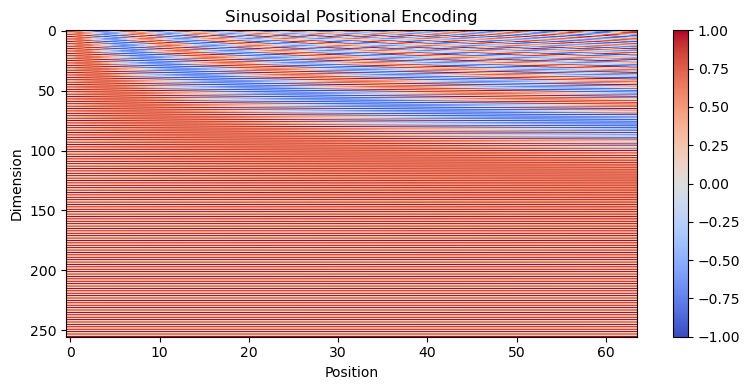

In [42]:
plt.figure(figsize=(8, 4))
plt.imshow(pe2.T, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Sinusoidal Positional Encoding')
plt.xlabel('Position')
plt.ylabel('Dimension')
plt.tight_layout()
plt.show()